# Table - elsa training

In [ ]:
import mlflow
import pandas as pd

run_ids = ['4a43996d7eec489183ad0d6b0c00d935',
           '0c2c7c4b7cd5427db21b9c7022ffbc18']

data = []
runs = [mlflow.get_run(run_id) for run_id in run_ids]
for run in runs: 
    params = run.data.params
    metrics_data = run.data.metrics   
    values = {
        'Dataset': params['dataset'],
        'NDCG@20': metrics_data['NDCG20/test'],
        'Recall@20': metrics_data['R20/test']
    }
    data.append(values)
df = pd.DataFrame(data)
df = df.sort_values(by='NDCG@20', ascending=True).reset_index(drop=True)
df.to_latex(
    'results.tex',
    index=False,
    float_format='%.3f',
    escape=False,
    label='tab:elsa:results',
    caption='Training performance metrics of the ELSA model evaluated on both datasets.'
)


# Table datasets

In [ ]:
from datasets import MovieLensLoader, LastFm1kLoader

class Config:
    val_ratio = 0.1
    test_ratio = 0.1
    seed = 42
    
movielens = MovieLensLoader()
movielens.prepare(Config())

lastfm = LastFm1kLoader()
lastfm.prepare(Config())

number_of_interactions = lastfm.csr_interactions.data.shape[0] 

In [10]:
import pandas as pd


data = {}
for dataset in [movielens, lastfm]:
    data[dataset.name] = {
        '# Users': len(dataset.users),
        '# Items': len(dataset.items),
        '# Interactions': dataset.csr_interactions.nnz,
        'Sparsity': f'{dataset.csr_interactions.nnz / (len(dataset.users) * len(dataset.items)):.2%}',
        'Average Interactions per User': f'{dataset.csr_interactions.nnz / len(dataset.users):.2f}',
        'Average Interactions per Item': f'{dataset.csr_interactions.nnz / len(dataset.items):.2f}',
    }
    
df = pd.DataFrame(data)
df.to_latex(
    'dataset_stats.tex',
    index=True,
    float_format='%.2f',
    escape=True,
    label='tab:datasets',
    caption='Statistics of the datasets.'
)
df

,MovieLens,LastFM1k
# Users,88897,988
# Items,14069,13794
# Interactions,13034935,607453
Sparsity,1.04%,4.46%
Average Interactions per User,146.63,614.83
Average Interactions per Item,926.50,44.04


In [4]:
import mlflow
import pandas as pd

experiment_ids = ['523100174176986081']#, '333391697323445885']
    
group_types = ['sim', 'random', 'outlier']
    
# variants = [
#     ('average', 'True'),
#     ('average', 'False'),
#     ('common_features', 'True'),
#     ('common_features', 'False'),
#     ('max', 'True'),
#     ('max', 'False'),
#     ('topk', 'True'),
#     ('topk', 'False'),
#     ('wcom', 'True'),
#     ('wcom', 'False'),
    
# ]

variants = [
    'average',
    'common_features',
    'max',
    'topk',
    'wcom',
]

runs_to_reuse = []

for exp_id in experiment_ids:
    for group_type in group_types:
        for variant in variants:
            # aggregation, activation = variant
            aggregation = variant
            runs = mlflow.search_runs(
                experiment_ids=[exp_id],
                # filter_string=f"params.SAE_fusion_strategy = '{aggregation}' and params.topk_inference = '{activation}' and params.group_type = '{group_type}'",
                filter_string=f"params.SAE_fusion_strategy = '{aggregation}' and params.group_type = '{group_type}' and params.user_set = 'valid'",
                
                output_format="list"
            )
            runs = [run for run in runs if "aggregations" in run.data.params.get("note", "")]
            print(f"Number of runs: {len(runs)}")
            
            runs_metrics = []
            gs = [run.data.metrics.get("NDCG20_com") for run in runs]
            us = [run.data.metrics.get("NDCG20_min") for run in runs]
            gs_rank = pd.Series(gs).rank(ascending=False, method='min')
            us_rank = pd.Series(us).rank(ascending=False, method='min')
            overall_rank = [g + u for g, u in zip(gs_rank, us_rank)]
            
            best_index = overall_rank.index(min(overall_rank))
            best_run = runs[best_index]
            print(f"Best run ID: {best_run.info.run_id}, G Rank: {gs_rank[best_index]}, G: {gs[best_index]}, U Rank: {us_rank[best_index]}, U: {us[best_index]}, Overall Rank: {overall_rank[best_index]}")
            
            runs_to_reuse.append({
                "sae_fusion_strategy": aggregation,
                "topk_inference": True if best_run.data.params.get("topk_inference") == "True" else False,
                "group_type": group_type,
                "sae_run_id": best_run.data.params.get("sae_run_id"),
                "dataset": best_run.data.params.get("dataset"),
                "user_set": "test",
                "dimensions": best_run.data.params.get("embedding_dim"),
                "k": best_run.data.params.get('top_k')
            })
            print(runs_to_reuse[-1])


Number of runs: 18
Best run ID: 6840e8c0d6a6457487688fd23cb51f2d, G Rank: 1.0, G: 0.6333997249603271, U Rank: 1.0, U: 0.5534828305244446, Overall Rank: 2.0
{'sae_fusion_strategy': 'average', 'topk_inference': True, 'group_type': 'sim', 'sae_run_id': '622c05b8482a4760bd530de942d60087', 'dataset': 'MovieLens', 'user_set': 'test', 'dimensions': '2048', 'k': '128'}
Number of runs: 18
Best run ID: c9a401785b5945309acd845b55d3bc45, G Rank: 1.0, G: 0.5883604884147644, U Rank: 1.0, U: 0.5163213014602661, Overall Rank: 2.0
{'sae_fusion_strategy': 'common_features', 'topk_inference': False, 'group_type': 'sim', 'sae_run_id': '6820409741044eafb5d1758073ae771e', 'dataset': 'MovieLens', 'user_set': 'test', 'dimensions': '4096', 'k': '64'}
Number of runs: 18
Best run ID: 6a10015860dc4c1782c655730697d047, G Rank: 1.0, G: 0.6202012896537781, U Rank: 1.0, U: 0.5480246543884277, Overall Rank: 2.0
{'sae_fusion_strategy': 'max', 'topk_inference': True, 'group_type': 'sim', 'sae_run_id': 'b6f471cb3b41454ab

In [5]:
import subprocess
        
for run in runs_to_reuse:
    note = "big-fight"
    cmd = [
        'python', 'recommend_for_groups.py',
        '--dataset', run['dataset'],
        '--sae_run_id', run['sae_run_id'],
        '--use_base_model_from_sae',
        '--recommender_strategy', 'SAE',
        '--SAE_fusion_strategy', run['sae_fusion_strategy'],
        '--group_type', run['group_type'],
        '--group_size', '3',
        '--user_set', run['user_set'],
        '--note', note,
        '--group_set', 'test',
    ]
    if run['topk_inference']:
        cmd.append('--topk_inference')
    print('Running:', ' '.join(cmd))
    subprocess.run(cmd, check=True)

Running: python recommend_for_groups.py --dataset MovieLens --sae_run_id 622c05b8482a4760bd530de942d60087 --use_base_model_from_sae --recommender_strategy SAE --SAE_fusion_strategy average --group_type sim --group_size 3 --user_set test --note big-fight --group_set test --topk_inference
2025-07-02 14:56:07,167 [INFO] Recommending with GR System - 2025-07-02_14-56-07
2025-07-02 14:56:07,184 [INFO] Device: mps
2025-07-02 14:56:07,186 [INFO] Preparing dataset: MovieLens
2025-07-02 14:56:07,186 [INFO] The dataset has already been prepared. Loading cached file...
2025-07-02 14:56:07,217 [INFO] Dataset loaded in 0.03s
2025-07-02 14:56:07,529 [INFO] Final interactions: 13034935, users: 88897, items: 14069
2025-07-02 14:56:07,529 [INFO] Creating csr_matrix...
2025-07-02 14:56:08,353 [INFO] csr_matrix created in 1.14s
2025-07-02 14:56:08,353 [INFO] Splitting dataset...
2025-07-02 14:56:08,388 [INFO] Dataset split in 0.04s
2025-07-02 14:56:08,388 [INFO] --------------------
2025-07-02 14:56:08,3

Group Recommending: 100%|██████████| 1000/1000 [00:21<00:00, 45.69it/s]


2025-07-02 14:56:36,227 [INFO] Logs successfully saved
Running: python recommend_for_groups.py --dataset MovieLens --sae_run_id 6820409741044eafb5d1758073ae771e --use_base_model_from_sae --recommender_strategy SAE --SAE_fusion_strategy common_features --group_type sim --group_size 3 --user_set test --note big-fight --group_set test
2025-07-02 14:56:40,809 [INFO] Recommending with GR System - 2025-07-02_14-56-40
2025-07-02 14:56:40,828 [INFO] Device: mps
2025-07-02 14:56:40,829 [INFO] Preparing dataset: MovieLens
2025-07-02 14:56:40,829 [INFO] The dataset has already been prepared. Loading cached file...
2025-07-02 14:56:40,845 [INFO] Dataset loaded in 0.02s
2025-07-02 14:56:40,944 [INFO] Final interactions: 13034935, users: 88897, items: 14069
2025-07-02 14:56:40,944 [INFO] Creating csr_matrix...
2025-07-02 14:56:41,735 [INFO] csr_matrix created in 0.89s
2025-07-02 14:56:41,735 [INFO] Splitting dataset...
2025-07-02 14:56:41,774 [INFO] Dataset split in 0.04s
2025-07-02 14:56:41,774 [IN

Group Recommending: 100%|██████████| 1000/1000 [00:18<00:00, 53.63it/s]


2025-07-02 14:57:05,902 [INFO] Logs successfully saved
Running: python recommend_for_groups.py --dataset MovieLens --sae_run_id b6f471cb3b41454ab2a52932b403ade9 --use_base_model_from_sae --recommender_strategy SAE --SAE_fusion_strategy max --group_type sim --group_size 3 --user_set test --note big-fight --group_set test --topk_inference
2025-07-02 14:57:10,185 [INFO] Recommending with GR System - 2025-07-02_14-57-10
2025-07-02 14:57:10,200 [INFO] Device: mps
2025-07-02 14:57:10,201 [INFO] Preparing dataset: MovieLens
2025-07-02 14:57:10,201 [INFO] The dataset has already been prepared. Loading cached file...
2025-07-02 14:57:10,216 [INFO] Dataset loaded in 0.02s
2025-07-02 14:57:10,318 [INFO] Final interactions: 13034935, users: 88897, items: 14069
2025-07-02 14:57:10,318 [INFO] Creating csr_matrix...
2025-07-02 14:57:11,109 [INFO] csr_matrix created in 0.89s
2025-07-02 14:57:11,110 [INFO] Splitting dataset...
2025-07-02 14:57:11,145 [INFO] Dataset split in 0.04s
2025-07-02 14:57:11,14

Group Recommending: 100%|██████████| 1000/1000 [00:20<00:00, 48.90it/s]


2025-07-02 14:57:37,150 [INFO] Logs successfully saved
Running: python recommend_for_groups.py --dataset MovieLens --sae_run_id 622c05b8482a4760bd530de942d60087 --use_base_model_from_sae --recommender_strategy SAE --SAE_fusion_strategy topk --group_type sim --group_size 3 --user_set test --note big-fight --group_set test --topk_inference
2025-07-02 14:57:41,358 [INFO] Recommending with GR System - 2025-07-02_14-57-41
2025-07-02 14:57:41,373 [INFO] Device: mps
2025-07-02 14:57:41,374 [INFO] Preparing dataset: MovieLens
2025-07-02 14:57:41,374 [INFO] The dataset has already been prepared. Loading cached file...
2025-07-02 14:57:41,389 [INFO] Dataset loaded in 0.02s
2025-07-02 14:57:41,490 [INFO] Final interactions: 13034935, users: 88897, items: 14069
2025-07-02 14:57:41,490 [INFO] Creating csr_matrix...
2025-07-02 14:57:42,287 [INFO] csr_matrix created in 0.90s
2025-07-02 14:57:42,287 [INFO] Splitting dataset...
2025-07-02 14:57:42,321 [INFO] Dataset split in 0.03s
2025-07-02 14:57:42,3

Group Recommending: 100%|██████████| 1000/1000 [00:21<00:00, 46.64it/s]


2025-07-02 14:58:09,360 [INFO] Logs successfully saved
Running: python recommend_for_groups.py --dataset MovieLens --sae_run_id b6f471cb3b41454ab2a52932b403ade9 --use_base_model_from_sae --recommender_strategy SAE --SAE_fusion_strategy wcom --group_type sim --group_size 3 --user_set test --note big-fight --group_set test
2025-07-02 14:58:13,911 [INFO] Recommending with GR System - 2025-07-02_14-58-13
2025-07-02 14:58:13,926 [INFO] Device: mps
2025-07-02 14:58:13,927 [INFO] Preparing dataset: MovieLens
2025-07-02 14:58:13,927 [INFO] The dataset has already been prepared. Loading cached file...
2025-07-02 14:58:13,942 [INFO] Dataset loaded in 0.02s
2025-07-02 14:58:14,044 [INFO] Final interactions: 13034935, users: 88897, items: 14069
2025-07-02 14:58:14,044 [INFO] Creating csr_matrix...
2025-07-02 14:58:14,840 [INFO] csr_matrix created in 0.90s
2025-07-02 14:58:14,840 [INFO] Splitting dataset...
2025-07-02 14:58:14,875 [INFO] Dataset split in 0.04s
2025-07-02 14:58:14,875 [INFO] -------

Group Recommending: 100%|██████████| 1000/1000 [00:23<00:00, 42.04it/s]


2025-07-02 14:58:45,254 [INFO] Logs successfully saved
Running: python recommend_for_groups.py --dataset MovieLens --sae_run_id b6f471cb3b41454ab2a52932b403ade9 --use_base_model_from_sae --recommender_strategy SAE --SAE_fusion_strategy average --group_type random --group_size 3 --user_set test --note big-fight --group_set test --topk_inference
2025-07-02 14:58:49,832 [INFO] Recommending with GR System - 2025-07-02_14-58-49
2025-07-02 14:58:49,849 [INFO] Device: mps
2025-07-02 14:58:49,851 [INFO] Preparing dataset: MovieLens
2025-07-02 14:58:49,851 [INFO] The dataset has already been prepared. Loading cached file...
2025-07-02 14:58:49,868 [INFO] Dataset loaded in 0.02s
2025-07-02 14:58:49,983 [INFO] Final interactions: 13034935, users: 88897, items: 14069
2025-07-02 14:58:49,983 [INFO] Creating csr_matrix...
2025-07-02 14:58:50,860 [INFO] csr_matrix created in 0.99s
2025-07-02 14:58:50,861 [INFO] Splitting dataset...
2025-07-02 14:58:50,895 [INFO] Dataset split in 0.03s
2025-07-02 14:5

Group Recommending: 100%|██████████| 1000/1000 [00:20<00:00, 49.85it/s]


2025-07-02 14:59:16,606 [INFO] Logs successfully saved
Running: python recommend_for_groups.py --dataset MovieLens --sae_run_id d3945a0ac9da4064b8e8a5017f68eafc --use_base_model_from_sae --recommender_strategy SAE --SAE_fusion_strategy common_features --group_type random --group_size 3 --user_set test --note big-fight --group_set test
2025-07-02 14:59:21,067 [INFO] Recommending with GR System - 2025-07-02_14-59-21
2025-07-02 14:59:21,085 [INFO] Device: mps
2025-07-02 14:59:21,086 [INFO] Preparing dataset: MovieLens
2025-07-02 14:59:21,086 [INFO] The dataset has already been prepared. Loading cached file...
2025-07-02 14:59:21,102 [INFO] Dataset loaded in 0.02s
2025-07-02 14:59:21,202 [INFO] Final interactions: 13034935, users: 88897, items: 14069
2025-07-02 14:59:21,202 [INFO] Creating csr_matrix...
2025-07-02 14:59:21,991 [INFO] csr_matrix created in 0.89s
2025-07-02 14:59:21,991 [INFO] Splitting dataset...
2025-07-02 14:59:22,027 [INFO] Dataset split in 0.04s
2025-07-02 14:59:22,027 

Group Recommending: 100%|██████████| 1000/1000 [00:18<00:00, 53.09it/s]


2025-07-02 14:59:46,432 [INFO] Logs successfully saved
Running: python recommend_for_groups.py --dataset MovieLens --sae_run_id 622c05b8482a4760bd530de942d60087 --use_base_model_from_sae --recommender_strategy SAE --SAE_fusion_strategy max --group_type random --group_size 3 --user_set test --note big-fight --group_set test --topk_inference
2025-07-02 14:59:50,993 [INFO] Recommending with GR System - 2025-07-02_14-59-50
2025-07-02 14:59:51,010 [INFO] Device: mps
2025-07-02 14:59:51,011 [INFO] Preparing dataset: MovieLens
2025-07-02 14:59:51,011 [INFO] The dataset has already been prepared. Loading cached file...
2025-07-02 14:59:51,026 [INFO] Dataset loaded in 0.02s
2025-07-02 14:59:51,132 [INFO] Final interactions: 13034935, users: 88897, items: 14069
2025-07-02 14:59:51,132 [INFO] Creating csr_matrix...
2025-07-02 14:59:51,941 [INFO] csr_matrix created in 0.91s
2025-07-02 14:59:51,941 [INFO] Splitting dataset...
2025-07-02 14:59:51,976 [INFO] Dataset split in 0.04s
2025-07-02 14:59:51

Group Recommending: 100%|██████████| 1000/1000 [00:19<00:00, 51.19it/s]


2025-07-02 15:00:17,060 [INFO] Logs successfully saved
Running: python recommend_for_groups.py --dataset MovieLens --sae_run_id dbaee95cb7874645a528d0830d6be525 --use_base_model_from_sae --recommender_strategy SAE --SAE_fusion_strategy topk --group_type random --group_size 3 --user_set test --note big-fight --group_set test
2025-07-02 15:00:21,660 [INFO] Recommending with GR System - 2025-07-02_15-00-21
2025-07-02 15:00:21,677 [INFO] Device: mps
2025-07-02 15:00:21,678 [INFO] Preparing dataset: MovieLens
2025-07-02 15:00:21,678 [INFO] The dataset has already been prepared. Loading cached file...
2025-07-02 15:00:21,693 [INFO] Dataset loaded in 0.02s
2025-07-02 15:00:21,800 [INFO] Final interactions: 13034935, users: 88897, items: 14069
2025-07-02 15:00:21,800 [INFO] Creating csr_matrix...
2025-07-02 15:00:22,591 [INFO] csr_matrix created in 0.90s
2025-07-02 15:00:22,591 [INFO] Splitting dataset...
2025-07-02 15:00:22,626 [INFO] Dataset split in 0.04s
2025-07-02 15:00:22,627 [INFO] ----

Group Recommending: 100%|██████████| 1000/1000 [00:19<00:00, 50.63it/s]


2025-07-02 15:00:48,003 [INFO] Logs successfully saved
Running: python recommend_for_groups.py --dataset MovieLens --sae_run_id dbaee95cb7874645a528d0830d6be525 --use_base_model_from_sae --recommender_strategy SAE --SAE_fusion_strategy wcom --group_type random --group_size 3 --user_set test --note big-fight --group_set test --topk_inference
2025-07-02 15:00:52,757 [INFO] Recommending with GR System - 2025-07-02_15-00-52
2025-07-02 15:00:52,779 [INFO] Device: mps
2025-07-02 15:00:52,780 [INFO] Preparing dataset: MovieLens
2025-07-02 15:00:52,781 [INFO] The dataset has already been prepared. Loading cached file...
2025-07-02 15:00:52,797 [INFO] Dataset loaded in 0.02s
2025-07-02 15:00:52,897 [INFO] Final interactions: 13034935, users: 88897, items: 14069
2025-07-02 15:00:52,897 [INFO] Creating csr_matrix...
2025-07-02 15:00:53,677 [INFO] csr_matrix created in 0.88s
2025-07-02 15:00:53,677 [INFO] Splitting dataset...
2025-07-02 15:00:53,712 [INFO] Dataset split in 0.04s
2025-07-02 15:00:5

Group Recommending: 100%|██████████| 1000/1000 [00:19<00:00, 52.06it/s]


2025-07-02 15:01:18,654 [INFO] Logs successfully saved
Running: python recommend_for_groups.py --dataset MovieLens --sae_run_id bbae35b675674be99f7ec013dc869b35 --use_base_model_from_sae --recommender_strategy SAE --SAE_fusion_strategy average --group_type outlier --group_size 3 --user_set test --note big-fight --group_set test --topk_inference
2025-07-02 15:01:22,952 [INFO] Recommending with GR System - 2025-07-02_15-01-22
2025-07-02 15:01:22,966 [INFO] Device: mps
2025-07-02 15:01:22,967 [INFO] Preparing dataset: MovieLens
2025-07-02 15:01:22,968 [INFO] The dataset has already been prepared. Loading cached file...
2025-07-02 15:01:22,982 [INFO] Dataset loaded in 0.01s
2025-07-02 15:01:23,077 [INFO] Final interactions: 13034935, users: 88897, items: 14069
2025-07-02 15:01:23,077 [INFO] Creating csr_matrix...
2025-07-02 15:01:23,861 [INFO] csr_matrix created in 0.88s
2025-07-02 15:01:23,861 [INFO] Splitting dataset...
2025-07-02 15:01:23,895 [INFO] Dataset split in 0.03s
2025-07-02 15:

Group Recommending: 100%|██████████| 1000/1000 [00:19<00:00, 50.43it/s]


2025-07-02 15:01:49,272 [INFO] Logs successfully saved
Running: python recommend_for_groups.py --dataset MovieLens --sae_run_id d3945a0ac9da4064b8e8a5017f68eafc --use_base_model_from_sae --recommender_strategy SAE --SAE_fusion_strategy common_features --group_type outlier --group_size 3 --user_set test --note big-fight --group_set test
2025-07-02 15:01:53,544 [INFO] Recommending with GR System - 2025-07-02_15-01-53
2025-07-02 15:01:53,558 [INFO] Device: mps
2025-07-02 15:01:53,559 [INFO] Preparing dataset: MovieLens
2025-07-02 15:01:53,559 [INFO] The dataset has already been prepared. Loading cached file...
2025-07-02 15:01:53,573 [INFO] Dataset loaded in 0.01s
2025-07-02 15:01:53,670 [INFO] Final interactions: 13034935, users: 88897, items: 14069
2025-07-02 15:01:53,671 [INFO] Creating csr_matrix...
2025-07-02 15:01:54,454 [INFO] csr_matrix created in 0.88s
2025-07-02 15:01:54,454 [INFO] Splitting dataset...
2025-07-02 15:01:54,490 [INFO] Dataset split in 0.04s
2025-07-02 15:01:54,490

Group Recommending: 100%|██████████| 1000/1000 [00:18<00:00, 53.35it/s]


2025-07-02 15:02:18,765 [INFO] Logs successfully saved
Running: python recommend_for_groups.py --dataset MovieLens --sae_run_id b6f471cb3b41454ab2a52932b403ade9 --use_base_model_from_sae --recommender_strategy SAE --SAE_fusion_strategy max --group_type outlier --group_size 3 --user_set test --note big-fight --group_set test --topk_inference
2025-07-02 15:02:23,343 [INFO] Recommending with GR System - 2025-07-02_15-02-23
2025-07-02 15:02:23,357 [INFO] Device: mps
2025-07-02 15:02:23,359 [INFO] Preparing dataset: MovieLens
2025-07-02 15:02:23,359 [INFO] The dataset has already been prepared. Loading cached file...
2025-07-02 15:02:23,374 [INFO] Dataset loaded in 0.02s
2025-07-02 15:02:23,474 [INFO] Final interactions: 13034935, users: 88897, items: 14069
2025-07-02 15:02:23,474 [INFO] Creating csr_matrix...
2025-07-02 15:02:24,257 [INFO] csr_matrix created in 0.88s
2025-07-02 15:02:24,257 [INFO] Splitting dataset...
2025-07-02 15:02:24,291 [INFO] Dataset split in 0.03s
2025-07-02 15:02:2

Group Recommending: 100%|██████████| 1000/1000 [00:20<00:00, 49.77it/s]


2025-07-02 15:02:49,963 [INFO] Logs successfully saved
Running: python recommend_for_groups.py --dataset MovieLens --sae_run_id dbaee95cb7874645a528d0830d6be525 --use_base_model_from_sae --recommender_strategy SAE --SAE_fusion_strategy topk --group_type outlier --group_size 3 --user_set test --note big-fight --group_set test --topk_inference
2025-07-02 15:02:54,662 [INFO] Recommending with GR System - 2025-07-02_15-02-54
2025-07-02 15:02:54,677 [INFO] Device: mps
2025-07-02 15:02:54,678 [INFO] Preparing dataset: MovieLens
2025-07-02 15:02:54,678 [INFO] The dataset has already been prepared. Loading cached file...
2025-07-02 15:02:54,693 [INFO] Dataset loaded in 0.01s
2025-07-02 15:02:54,793 [INFO] Final interactions: 13034935, users: 88897, items: 14069
2025-07-02 15:02:54,793 [INFO] Creating csr_matrix...
2025-07-02 15:02:55,578 [INFO] csr_matrix created in 0.88s
2025-07-02 15:02:55,578 [INFO] Splitting dataset...
2025-07-02 15:02:55,612 [INFO] Dataset split in 0.03s
2025-07-02 15:02:

Group Recommending: 100%|██████████| 1000/1000 [00:19<00:00, 51.86it/s]


2025-07-02 15:03:20,521 [INFO] Logs successfully saved
Running: python recommend_for_groups.py --dataset MovieLens --sae_run_id dbaee95cb7874645a528d0830d6be525 --use_base_model_from_sae --recommender_strategy SAE --SAE_fusion_strategy wcom --group_type outlier --group_size 3 --user_set test --note big-fight --group_set test --topk_inference
2025-07-02 15:03:24,954 [INFO] Recommending with GR System - 2025-07-02_15-03-24
2025-07-02 15:03:24,970 [INFO] Device: mps
2025-07-02 15:03:24,971 [INFO] Preparing dataset: MovieLens
2025-07-02 15:03:24,971 [INFO] The dataset has already been prepared. Loading cached file...
2025-07-02 15:03:24,985 [INFO] Dataset loaded in 0.01s
2025-07-02 15:03:25,087 [INFO] Final interactions: 13034935, users: 88897, items: 14069
2025-07-02 15:03:25,088 [INFO] Creating csr_matrix...
2025-07-02 15:03:25,913 [INFO] csr_matrix created in 0.93s
2025-07-02 15:03:25,913 [INFO] Splitting dataset...
2025-07-02 15:03:25,948 [INFO] Dataset split in 0.04s
2025-07-02 15:03:

Group Recommending: 100%|██████████| 1000/1000 [00:19<00:00, 50.27it/s]


2025-07-02 15:03:51,573 [INFO] Logs successfully saved


# Similarity plots

In [39]:

expriment_ids = ['523100174176986081', '333391697323445885']
import rbo

import numpy as np
import mlflow
# recommendations8 = np.load('/Users/vitkostejn/school/diploma_thesis/code/mlruns/333391697323445885/f269ae43996d4e99944b8e5a5a06581d/artifacts/recommendations.npy', allow_pickle=True) # bad common features

def get_runs(group_type, dataset):
    runs = mlflow.search_runs(expriment_ids,
                            filter_string=f"params.group_type = '{group_type}' and params.group_set = 'test' and params.dataset = '{dataset}' and params.user_set = 'full'",
                            output_format="list")
    print(f"Number of runs: {len(runs)}")
    return runs


In [44]:
import pickle

fusion_strategy_mapping = {
    'average': 'Avg',
    'common_features': 'ComF',
    'max': 'Max',
    'topk': 'TopK',
    'wcom': 'WCom',
}

def get_metric_data(runs, order = None):
    recommendations_dict = {}
    for run in runs:
        strategy = run.data.params.get("recommender_strategy")
        if strategy == "SAE":
            fusion_strategy = fusion_strategy_mapping.get(run.data.params.get("SAE_fusion_strategy"), run.data.params.get("SAE_fusion_strategy"))
            strategy += f"-{fusion_strategy}"
            print(strategy)
        artifact_path = run.info.artifact_uri.replace('file://', '') + '/logs.pkl'
        with open(artifact_path, 'rb') as f:
            recommendations = pickle.load(f)["Recommendations"]
        recommendations_dict[strategy] = recommendations

    if order:
        recommendations_dict = {k: recommendations_dict[k] for k in order}
    return recommendations_dict

In [45]:

def get_matrix_from_recommendations(recommendations_dict):
    similarity_matrix = np.zeros((len(recommendations_dict), len(recommendations_dict)))
    for i, rec1 in enumerate(recommendations_dict.values()):
        for j, rec2 in enumerate(recommendations_dict.values()):
            if i == j:
                similarity_matrix[i][j] = 1
            else:
                common_items = []
                for g in range(len(rec1)):
                    rec1_items = rec1[g][:10]
                    rec2_items = rec2[g][:10]
                    # Find items that all 3 users in the group have interacted with
                    # This creates a binary array where a value is 1 if all users interacted with that item
                    ci = len(np.intersect1d(rec1_items, rec2_items)) / len(rec1_items)
                    # ci = rbo.RankingSimilarity(rec1_items[:20], rec2_items[:20]).rbo(p=0.9)
                    common_items.append(ci)
                common_items = np.array(common_items)
                #sanity check
                similarity_matrix[i][j] = np.mean(common_items)
    return similarity_matrix

In [47]:
datasets = ['MovieLens', 'LastFM1k']
group_types = ['sim', 'random', 'outlier']

new_order = [
    'SAE-Avg',
    'SAE-ComF',
    'SAE-Max',
    'SAE-TopK',
    'SAE-WCom',
    'ELSA',
    'ELSA_INT',
    'ADD',
    'LMS',
    'MPL',
    'EPFuzzDA',
    'GFAR',
]


In [ ]:


similarity_matricies = {}
for dataset in datasets:
    for group_type in group_types:
        runs = get_runs(group_type, dataset)
        metrics_data = get_metric_data(runs, order=new_order)
        similarity_matrix = get_matrix_from_recommendations(metrics_data)
        similarity_matricies[(dataset, group_type)] = similarity_matrix
        print(f"Processed {dataset} - {group_type}")


similarity_matrix: (12, 12)
similarity_matrix: (12, 12)
similarity_matrix: (12, 12)
similarity_matrix: (12, 12)
similarity_matrix: (12, 12)
similarity_matrix: (12, 12)


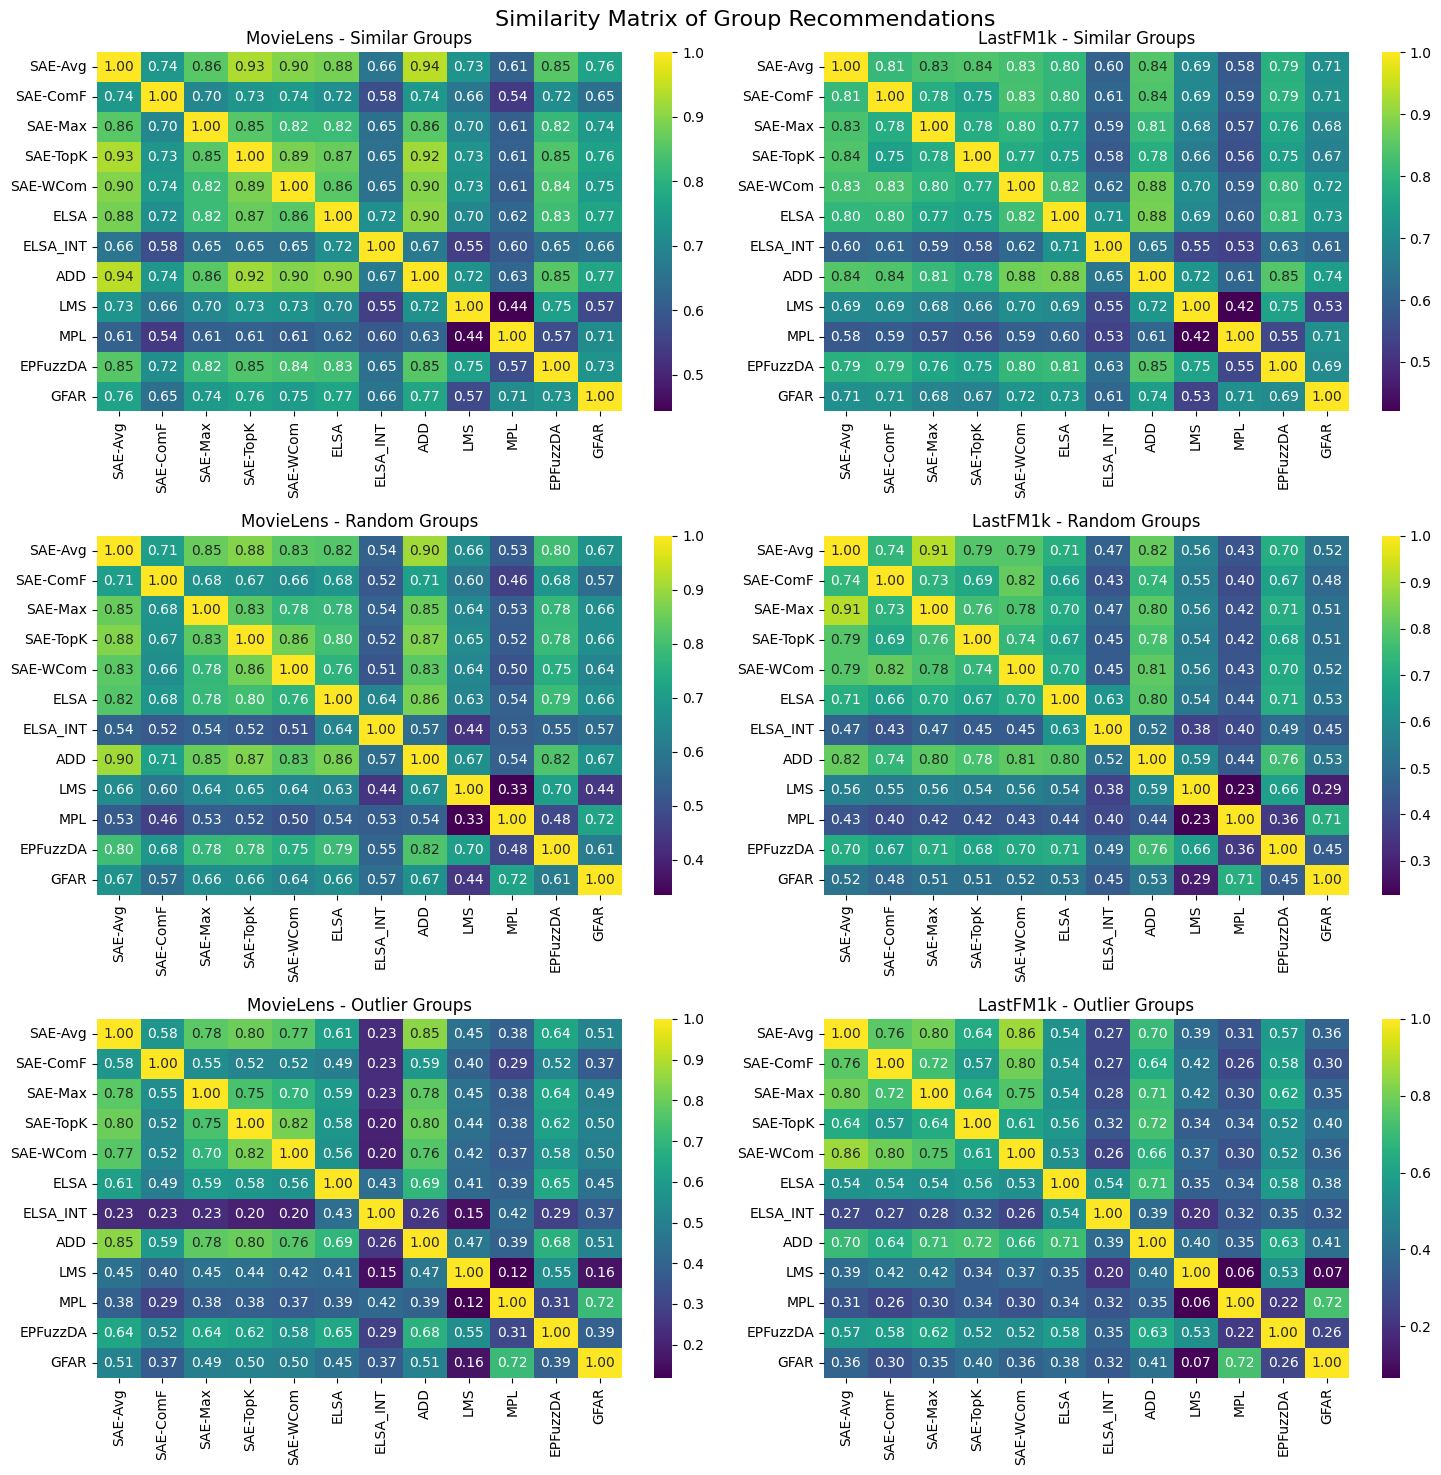

In [41]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

group_type_mapping = {
    'sim': 'Similar Groups',
    'random': 'Random Groups',
    'outlier': 'Outlier Groups'
}

fig, axes = plt.subplots(nrows=len(group_types), ncols=len(datasets), figsize=(15, 15))
for i, dataset in enumerate(datasets):
    for j, group_type in enumerate(group_types):
        ax = axes[j, i]
        similarity_matrix = similarity_matricies[(dataset, group_type)]
        print(f"similarity_matrix: {similarity_matrix.shape}")
        df = pd.DataFrame(similarity_matrix, index=new_order, columns=new_order)
        sns.heatmap(df, annot=True, cmap='viridis', fmt=".2f", ax=ax)
        ax.set_title(f"{dataset} - {group_type_mapping[group_type]}")
fig.suptitle('Similarity Matrix of Group Recommendations', fontsize=16)
plt.tight_layout()
plt.savefig('similarity_matrix.png', bbox_inches='tight', dpi=300)
plt.show()

similarity_matrix: (12, 12)
similarity_matrix: (12, 12)
similarity_matrix: (12, 12)
similarity_matrix: (12, 12)
similarity_matrix: (12, 12)
similarity_matrix: (12, 12)


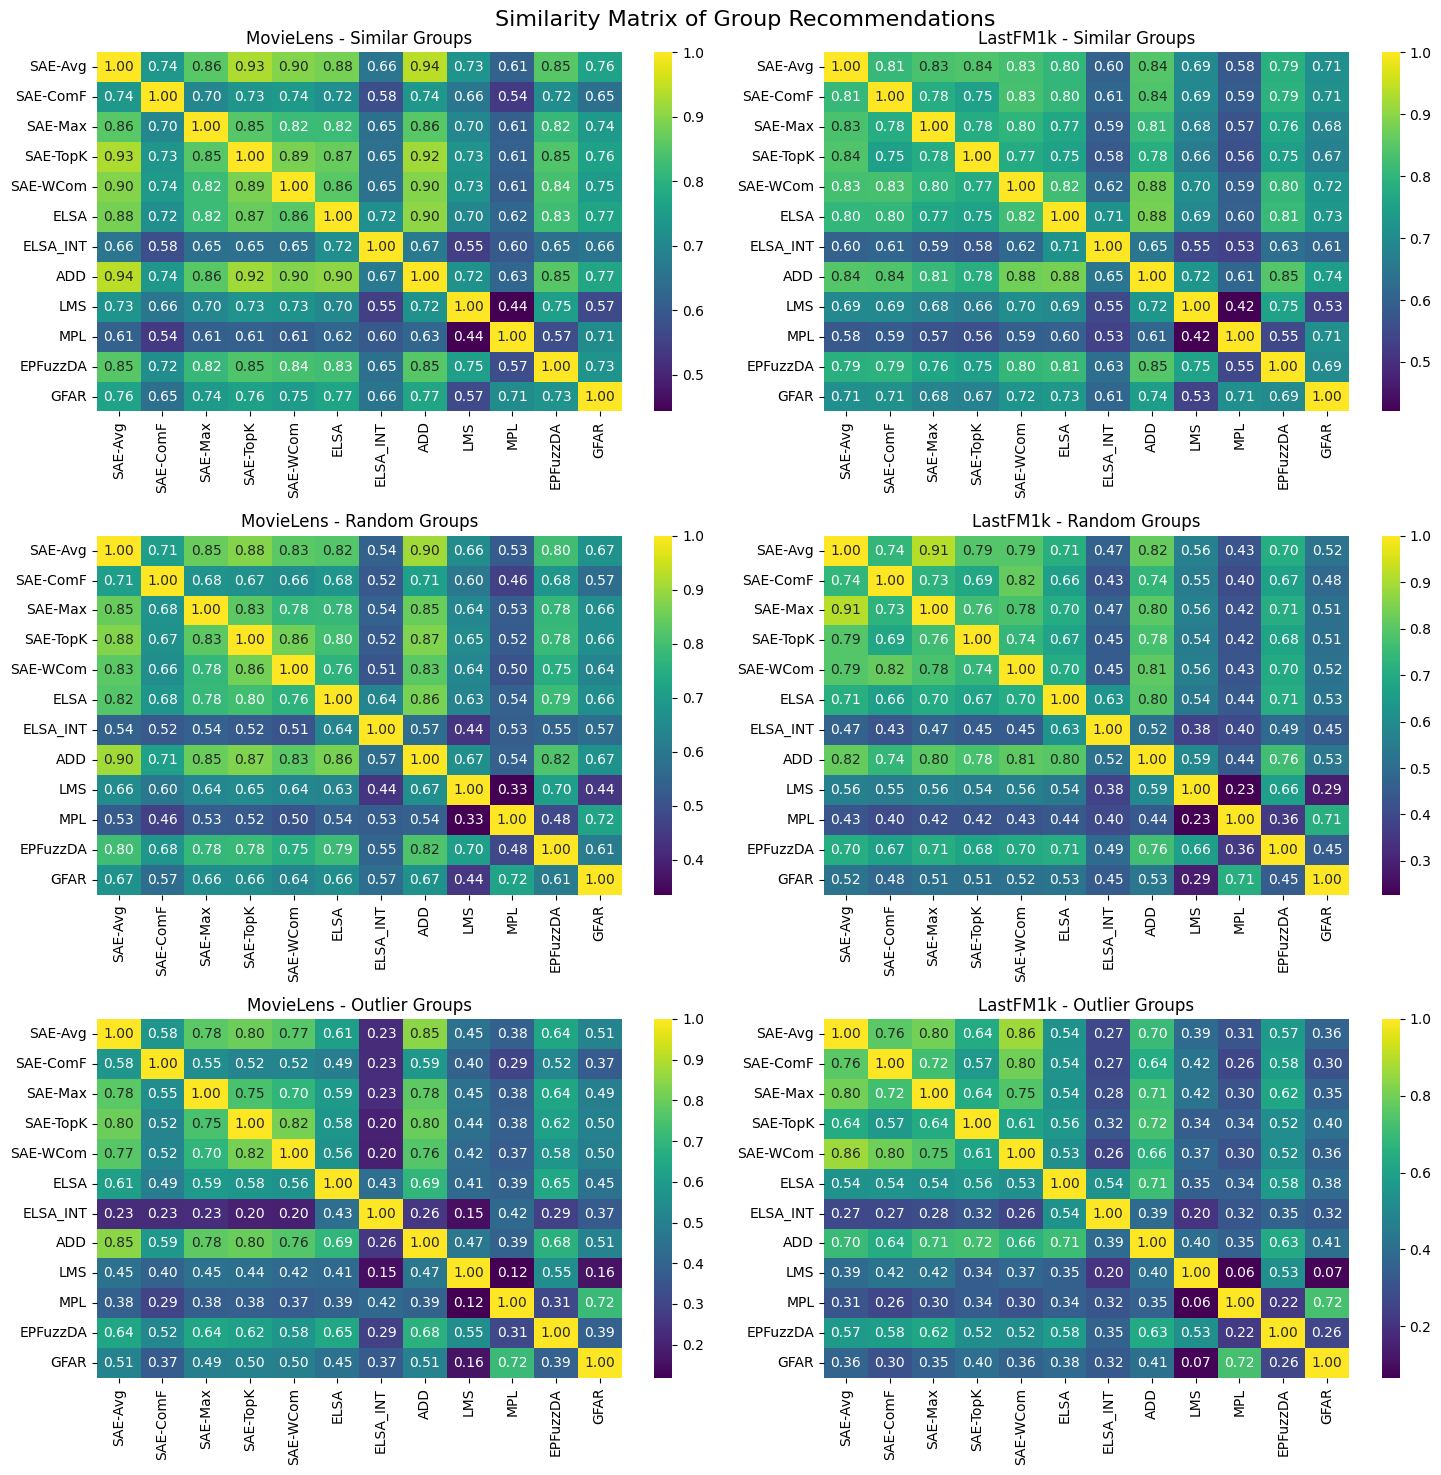

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

group_type_mapping = {
    'sim': 'Similar Groups',
    'random': 'Random Groups',
    'outlier': 'Outlier Groups'
}

fig, axes = plt.subplots(nrows=len(group_types), ncols=len(datasets), figsize=(15, 15))
for i, dataset in enumerate(datasets):
    for j, group_type in enumerate(group_types):
        ax = axes[j, i]
        similarity_matrix = similarity_matricies[(dataset, group_type)]
        print(f"similarity_matrix: {similarity_matrix.shape}")
        df = pd.DataFrame(similarity_matrix, index=new_order, columns=new_order)
        sns.heatmap(df, annot=True, cmap='viridis', fmt=".2f", ax=ax)
        ax.set_title(f"{dataset} - {group_type_mapping[group_type]}")
fig.suptitle('Similarity Matrix of Group Recommendations', fontsize=16)
plt.tight_layout()
plt.savefig('similarity_matrix.png', bbox_inches='tight', dpi=300)
plt.show()

In [48]:
aggregation_mapping = {
    "average": "Avg",
    "max": "Max",
    "common_features": "ComF",
    "wcom": "WCom",
    "topk": "TopK",
}

        # method = row['recommender_strategy']
        # if method == "SAE":
        #     aggregation = row['SAE_fusion_strategy']
        #     method += "-" + aggregation_mapping.get(aggregation, aggregation)
        # group_type = row['group_type']

def get_method_name(run):
    params = run.data.params
    method = params.get('recommender_strategy', 'Unknown')
    if method == "SAE":
        aggregation = params.get('SAE_fusion_strategy', 'Unknown')
        method += "-" + aggregation_mapping.get(aggregation, aggregation)
    return method.replace('_', '-')

In [49]:
import pickle

def get_metric_data(runs, metric='NDCG20'):
    metrics_data = {}
    for run in runs:
        strategy = get_method_name(run)
        artifact_path = run.info.artifact_uri.replace('file://', '') + '/logs.pkl'
        with open(artifact_path, 'rb') as f:
            data = pickle.load(f)
        metrics_data[strategy] = data[metric]
    return metrics_data

In [52]:
from scipy import stats

# t_stat, p_val = stats.ttest_rel(before, after, alternative='two-sided')  # SciPy ≥ 1.6
# print(f"t = {t_stat:.3f}  p = {p_val:.4f}")

metrics = ['Popularity']

dataset = datasets[0]
group_type = group_types[0]
metric = metrics[0]
# runs = get_runs(group_type, dataset)



# metrics_data = get_metric_data(runs, metric=metric)

In [53]:

for dataset in datasets:
    for group_type in group_types:
        for metric in metrics:
            print(f"Dataset: {dataset}, Group Type: {group_type}, Metric: {metric}")
            runs = get_runs(group_type, dataset)
            metrics_data = get_metric_data(runs, metric=metric)
            sorted_metrics = sorted(metrics_data.items(), key=lambda x: x[1].mean(), reverse=False)
            highest_value_name = sorted_metrics[0][0]
            print(f"Highest value: {highest_value_name} with mean {sorted_metrics[0][1].mean():.3f}")
            metrics_data = {k: v for k, v in sorted_metrics}

            for name, values in metrics_data.items():
                # print(f"{name}: {values.mean():.3f} ± {values.std():.3f} (n={values.shape})")
                t_stat, p_val = stats.ttest_rel(metrics_data[highest_value_name].squeeze(), values.squeeze(), alternative='less')
                print(f"{name}: t = {t_stat:.3f}  p = {p_val:.4f}")
                if p_val >= 0.05:
                    print(f"{name}: NOT SIGNIFICANTLY DIFFERENT")
            print("\n" + "="*50 + "\n")


Dataset: MovieLens, Group Type: sim, Metric: Popularity
Number of runs: 12
Highest value: ELSA-INT with mean 0.427
ELSA-INT: t = nan  p = nan
MPL: t = -6.899  p = 0.0000
GFAR: t = -16.736  p = 0.0000
SAE-ComF: t = -14.010  p = 0.0000
LMS: t = -19.408  p = 0.0000
SAE-WCom: t = -23.287  p = 0.0000
EPFuzzDA: t = -26.547  p = 0.0000
ELSA: t = -33.287  p = 0.0000
SAE-Avg: t = -28.398  p = 0.0000
ADD: t = -29.955  p = 0.0000
SAE-TopK: t = -28.736  p = 0.0000
SAE-Max: t = -30.031  p = 0.0000


Dataset: MovieLens, Group Type: random, Metric: Popularity
Number of runs: 12
Highest value: ELSA-INT with mean 0.414
ELSA-INT: t = nan  p = nan
MPL: t = -11.785  p = 0.0000
GFAR: t = -20.818  p = 0.0000
SAE-ComF: t = -20.167  p = 0.0000
LMS: t = -26.176  p = 0.0000
ELSA: t = -39.689  p = 0.0000
EPFuzzDA: t = -33.069  p = 0.0000
SAE-WCom: t = -31.100  p = 0.0000
SAE-Max: t = -34.775  p = 0.0000
ADD: t = -35.919  p = 0.0000
SAE-Avg: t = -35.092  p = 0.0000
SAE-TopK: t = -36.122  p = 0.0000


Dataset: Mov

In [54]:
import mlflow
import pandas as pd

experiment_id = '523100174176986081'
# params.group_set = 'test' and params.user_set = 'test'
runs = mlflow.search_runs(
    experiment_ids=[experiment_id],
    filter_string="params.group_set = 'test' and params.user_set = 'test'",
    output_format="list"
)

In [56]:
from scipy import stats

significance = []

group_types = ['sim', 'random', 'outlier']
metrics = ['NDCG20_com', 'NDCG20_min', 'NDCG20_mean', 'Popularity/mean']
add_name_metrics = ['Group_NDCG', 'User_NDCG_Mins', 'User_NDCG_Means', 'Popularity']
official_metrics = ['$NDCG_{com}$', '$NDCG_{min}$', '$NDCG_{mean}$', 'Popularity']
for group_type in group_types:
    print(f"Group Type: {group_type.upper()}")
    group_runs = [run for run in runs if run.data.params.get('group_type') == group_type]
    print(f"Number of runs: {len(group_runs)}")
    for metric, add_name_metric, official_metric in zip(metrics, add_name_metrics, official_metrics):
        metric_data = get_metric_data(group_runs, metric=add_name_metric)
        ff = min if official_metric == 'Popularity' else max
        best_run = ff(metric_data.items(), key=lambda x: x[1].mean())
        print(f"Best {add_name_metric} for {group_type} groups: {best_run[0]} with mean {best_run[1].mean():.3f} and std {best_run[1].std():.3f}")
        
        # Get significance to the best run
        for i, run in enumerate(group_runs):
            strategy = get_method_name(run)
            data = {
                'Group Type': group_type,
                'Metric': official_metric,
                'Strategy': strategy,
                'Value': metric_data[strategy].mean(),
            }
            curr_results = metric_data[strategy]
            alternative = 'greater' if official_metric != 'Popularity' else 'less'
            t_stat, p_val = stats.ttest_rel(best_run[1].squeeze(), curr_results.squeeze(), alternative=alternative)
            print(f"{strategy}: t = {t_stat:.3f}  p = {p_val:.4f}")
            data['p-value'] = p_val
            if p_val <= 0.05 and strategy != best_run[0]:
                data['Significant'] = True
            else:
                data['Significant'] = False
            significance.append(data)

Group Type: SIM
Number of runs: 13
Best Group_NDCG for sim groups: SAE-TopK with mean 0.639 and std 0.175
MPL: t = 39.420  p = 0.0000
EPFuzzDA: t = 3.794  p = 0.0001
GFAR: t = 26.926  p = 0.0000
LMS: t = 5.889  p = 0.0000
ADD: t = 1.442  p = 0.0749
POPULAR: t = 37.411  p = 0.0000
SAE-WCom: t = 4.800  p = 0.0000
SAE-TopK: t = nan  p = nan
SAE-Max: t = 7.679  p = 0.0000
SAE-ComF: t = 12.313  p = 0.0000
SAE-Avg: t = 1.549  p = 0.0609
ELSA-INT: t = 29.603  p = 0.0000
ELSA: t = 10.837  p = 0.0000
Best User_NDCG_Mins for sim groups: SAE-TopK with mean 0.558 and std 0.125
MPL: t = 30.035  p = 0.0000
EPFuzzDA: t = 2.851  p = 0.0022
GFAR: t = 18.454  p = 0.0000
LMS: t = 10.187  p = 0.0000
ADD: t = 1.157  p = 0.1237
POPULAR: t = 39.956  p = 0.0000
SAE-WCom: t = 4.511  p = 0.0000
SAE-TopK: t = nan  p = nan
SAE-Max: t = 5.299  p = 0.0000
SAE-ComF: t = 13.381  p = 0.0000
SAE-Avg: t = 0.194  p = 0.4232
ELSA-INT: t = 29.505  p = 0.0000
ELSA: t = 16.341  p = 0.0000
Best User_NDCG_Means for sim groups:

In [57]:
df = pd.DataFrame(significance).sort_values(by=['Significant'], ascending=True)
df.head(20)
df.to_csv('paper/significance.csv', index=False)